In [1]:
"""DSP Case Study Code"""
import itertools
from typing import Tuple
from tool import PortWordLength, float_to_bin, port_add, port_mult
from pacti_counters import PolyhedralContractCounts, polyhedral_count_stats
from pacti.terms.polyhedra import PolyhedralContract

In [2]:
def truncation_error_same_position(pi: PortWordLength, po: PortWordLength) -> float:
    """
    Truncation error for the case where input ports and output ports have the same number of integer bits.

    Args:
        pi: PortWordLength: input port word length
        po: PortWordLength: input port word length

    Returns:
        The maximum truncation error if a number is truncated from wordlength pi to wordlength po
    """
    assert pi.p == po.p
    if pi.n > po.n:
        return float(2**po.p * (2 ** (-po.n) - 2 ** (-pi.n)))
    return 0


def truncate(pi: PortWordLength, po: PortWordLength) -> None:
    """
    Truncate the value in pi into po.

    Args:
        pi: PortWordLength: input port word length
        po: PortWordLength: input port word length
    """
    # separate the bits into two parts, before binary point and after binary point
    bits_str: str = str(pi.value)
    bits_before_point = bits_str[: pi.p]
    bits_after_point = bits_str[pi.p :]

    # truncate or appending 0
    if po.p >= pi.p:
        bits_before_point = ("0" * (po.p - pi.p)) + bits_before_point
    else:
        bits_before_point = bits_before_point[pi.p - po.p :]

    if po.n - po.p >= pi.n - pi.p:
        bits_after_point = bits_after_point + "0" * (po.n - po.p - pi.n + pi.p)
    else:
        bits_after_point = bits_after_point[: (po.n - po.p)]

    # combine the both parts
    ret = bits_before_point + bits_after_point
    po.value = ret

In [3]:
def truncation_error(pi: PortWordLength, po: PortWordLength) -> float:
    """
    Truncation error for the case where input ports and output ports have different number of integer bits.

    Args:
        pi: PortWordLength: input port word length
        po: PortWordLength: input port word length

    Returns:
        The maximum truncation error if a number is truncated from wordlength pi to wordlength po
    """
    # remove uneccesary most significant bits
    # Remider: The assumption must hold!!
    pi_adjusted = PortWordLength(n=pi.n - pi.p + po.p, p=po.p)
    # return the truncation error as in case 1
    return truncation_error_same_position(pi=pi_adjusted, po=po)


def get_assumption_value(pi: PortWordLength, po: PortWordLength) -> float:
    """
    Compute the assumption required for truncation to ensure no loss of integer values.

    Args:
        pi: PortWordLength: input port word length
        po: PortWordLength: input port word length

    Returns:
        The maximum bound pi such that it won't loss integer bits after truncation
    """
    if pi.p > po.p:
        return float(2**po.p)
    return float("inf")  # no additional assumption needed


def check_assumption_value(pi: PortWordLength, po: PortWordLength) -> bool:
    """
    Check if the value of the input port satisfy the assumption for truncation.

    Args:
        pi: PortWordLength: input port word length
        po: PortWordLength: input port word length

    Returns:
        If the assumption to prevent integer bit loss is satisfied
    """
    assumption_value = get_assumption_value(pi, po)
    # print(f"Assumption: {pi.name} < {assumption_value}")
    if pi.value_num() >= assumption_value:
        # print("Assumption failed, truncation of MSB occurs")
        return False

    # print(f"Assumption Satisfied ({pi.name} = {pi.value_num()} < {assumption_value})")
    return True

In [4]:
def compute_required_word_length_add(in1: PortWordLength, in2: PortWordLength) -> PortWordLength:
    """
    Compute the minimum word length to hold all values after addition operation on the inputs without lossing any information.

    Args:
        in1: PortWordLength: input port word length
        in2: PortWordLength: input port word length

    Returns:
        The minimum word length to hold all values after addition operation on the inputs without lossing any information.
    """
    new_n = max(in1.n, in2.n - in2.p + in1.p) - min(0, in1.p - in2.p) + 1
    new_p = max(in1.p, in2.p) + 1
    return PortWordLength(n=new_n, p=new_p)


def error_truncation_add(in1: PortWordLength, in2: PortWordLength, out: PortWordLength) -> float:
    """
    Compute the maximum error of truncation caused by the addition operation.

    The addition operation is perform for ports out = in1 + in2.
    The value of in1 + in2 is truncated to fit in out

    Args:
        in1: PortWordLength: input port word length
        in2: PortWordLength: input port word length
        out: PortWordLength: output port word length

    Returns:
        The maximum error of truncation caused by the addition operation
    """
    # print(f"Input {in1.name}: (n={in1.n}, p={in1.p})")
    # print(f"Input {in2.name}: (n={in2.n}, p={in2.p})")
    p_ideal = compute_required_word_length_add(in1=in1, in2=in2)
    # print(f"Ideal Output: (n={p_ideal.n}, p={p_ideal.p})")
    # print(f"Actual Output ({out.name}): (n={out.n}, p={out.p})")

    assumption_value = get_assumption_value(pi=p_ideal, po=out)
    # print(f"Assumption: {in1.name} + {in2.name} < {assumption_value}")
    return truncation_error(pi=p_ideal, po=out)

In [5]:
def compute_required_word_length_mult(in1: PortWordLength, in2: PortWordLength) -> PortWordLength:
    """
    Compute the minimum word length to hold all values after multiplication operation on the inputs without lossing any information.

    Args:
        in1: PortWordLength: input port word length
        in2: PortWordLength: input port word length

    Returns:
        The minimum word length to hold all values after multiplication operation on the inputs without lossing any information.
    """
    new_n = in1.n + in2.n
    new_p = in1.p + in2.p
    return PortWordLength(n=new_n, p=new_p)


def error_truncation_mult(in1: PortWordLength, in2: PortWordLength, out: PortWordLength) -> float:
    """
    Compute the maximum error of truncation caused by the multiplication operation.

    The multiplication operation is perform for ports out = in1 * in2.
    The value of in1 * in2 is truncated to fit in out

    Args:
        in1: PortWordLength: input port word length
        in2: PortWordLength: input port word length
        out: PortWordLength: output port word length

    Returns:
        The maximum error of truncation caused by the multiplication operation
    """
    # print(f"Input {in1.name}: (n={in1.n}, p={in1.p})")
    # print(f"Input {in2.name}: (n={in2.n}, p={in2.p})")
    p_ideal = compute_required_word_length_mult(in1=in1, in2=in2)
    # print(f"Ideal Output: (n={p_ideal.n}, p={p_ideal.p})")
    # print(f"Actual Output ({out.name}): (n={out.n}, p={out.p})")

    assumption_value = get_assumption_value(pi=p_ideal, po=out)
    # print(f"Assumption: {in1.name} * {in2.name} < {assumption_value}")
    return truncation_error(pi=p_ideal, po=out)

In [6]:
def form_contract_add(
    in_port1: PortWordLength, in_port2: PortWordLength, out_port: PortWordLength
) -> dict[str, object]:
    """
    Create contract in dictionary form for an addition operation.

    The contract includes information about the bound for its output value and the bound for its maximum error

    Args:
        in_port1: PortWordLength: input port word length
        in_port2: PortWordLength: input port word length
        out_port: PortWordLength: output port word length

    Returns:
        The contract in dictionary form for an addition operation.
    """
    ret_contract: dict[str, object] = {}
    # define input/output vars
    ret_contract["input_vars"] = [
        f"{in_port1.name}_a",
        f"{in_port1.name}_e",
        f"{in_port2.name}_a",
        f"{in_port2.name}_e",
    ]
    ret_contract["output_vars"] = [f"{out_port.name}_a", f"{out_port.name}_e"]
    # get assumption
    ideal_out_port = compute_required_word_length_add(in1=in_port1, in2=in_port2)
    assumption_value = get_assumption_value(pi=ideal_out_port, po=out_port)
    # write assumption in the contract
    if assumption_value == float("inf"):
        ret_contract["assumptions"] = []
    else:
        ret_contract["assumptions"] = [
            {"coefficients": {f"{in_port1.name}_a": 1, f"{in_port2.name}_a": 1}, "constant": assumption_value}
        ]
    # get guarantee
    e_trunc = truncation_error(pi=ideal_out_port, po=out_port)

    # write guarantee in the contract, note the propagation is encoded in the polyhedral constraints
    ret_contract["guarantees"] = [
        {
            "coefficients": {f"{in_port1.name}_e": -1, f"{in_port2.name}_e": -1, f"{out_port.name}_e": 1},
            "constant": e_trunc,
        },
        {"coefficients": {f"{out_port.name}_a": 1}, "constant": out_port.a},
        # {"coefficients":{f"{out_port.name}_a": 1}, "constant":in_port1.a + in_port2.a},
        {"coefficients": {f"{out_port.name}_a": 1, f"{in_port1.name}_a": -1, f"{in_port2.name}_a": -1}, "constant": 0},
    ]
    return ret_contract


def form_contract_mult_const(
    in_port: PortWordLength, in_port_const: PortWordLength, out_port: PortWordLength
) -> dict[str, object]:
    """
    Create contract in dictionary form for a constant coefficient multiplication operation.

    The contract includes information about the bound for its output value and the bound for its maximum error

    Args:
        in_port: PortWordLength: input port word length
        in_port_const: PortWordLength: constant input port word length
        out_port: PortWordLength: output port word length

    Returns:
        The contract in dictionary form for a constant coefficient multiplication operation.
    """
    ret_contract: dict[str, object] = {}
    # define input/output vars
    ret_contract["input_vars"] = [f"{in_port.name}_a", f"{in_port.name}_e"]
    ret_contract["output_vars"] = [f"{out_port.name}_a", f"{out_port.name}_e"]
    # get assumption
    ideal_out_port = compute_required_word_length_mult(in1=in_port, in2=in_port_const)
    assumption_value = get_assumption_value(pi=ideal_out_port, po=out_port)
    # write assumption in the contract
    if assumption_value == float("inf"):
        ret_contract["assumptions"] = []
    else:
        print(assumption_value)
        ret_contract["assumptions"] = [
            {"coefficients": {f"{in_port.name}_a": in_port_const.a}, "constant": assumption_value}
        ]
    # get guarantee
    # print(ideal_out_port.to_string())
    e_trunc = truncation_error(pi=ideal_out_port, po=out_port)

    # write guarantee in the contract, note the propagation is encoded in the polyhedral constraints
    ret_contract["guarantees"] = [
        {
            "coefficients": {
                f"{in_port.name}_e": -in_port_const.a + in_port_const.e,
                f"{in_port.name}_a": -in_port_const.e,
                f"{out_port.name}_e": 1,
            },
            "constant": e_trunc,
        },
        {"coefficients": {f"{out_port.name}_a": 1}, "constant": out_port.a},
        # {"coefficients":{f"{out_port.name}_a": 1}, "constant":in_port_const.a * in_port.a},
        {"coefficients": {f"{out_port.name}_a": 1, f"{in_port.name}_a": -in_port_const.a}, "constant": 0},
    ]
    return ret_contract

In [7]:
def form_contract_input(in_port: PortWordLength) -> dict[str, object]:
    """
    Create contract in dictionary form for a input port to the system.

    The contract includes information about the bound for its output value and the bound for its maximum error

    Args:
        in_port: PortWordLength: input port word length

    Returns:
        The contract in dictionary form for a input port to the system.
    """
    ret_contract: dict[str, object] = {}
    # define input/output vars
    ret_contract["input_vars"] = []
    ret_contract["output_vars"] = [f"{in_port.name}_a", f"{in_port.name}_e"]
    # get assumption
    ret_contract["assumptions"] = []
    ret_contract["guarantees"] = [
        {"coefficients": {f"{in_port.name}_a": 1}, "constant": in_port.a},
        {"coefficients": {f"{in_port.name}_a": -1}, "constant": 0},
        {"coefficients": {f"{in_port.name}_e": 1}, "constant": in_port.e},
        {"coefficients": {f"{in_port.name}_e": -1}, "constant": -in_port.e},
    ]
    return ret_contract

In [8]:
def example2_filter_design() -> None:
    """Example showing the composition of the filter design"""
    in1 = PortWordLength(n=6, p=0, e=0, name="in1")
    in2 = PortWordLength(n=6, p=0, e=0, name="in2")
    in3 = PortWordLength(n=6, p=0, e=0, name="in3")
    const1 = PortWordLength(n=6, p=0, name="const1")
    const2 = PortWordLength(n=6, p=0, name="const2")
    const3 = PortWordLength(n=6, p=0, name="const3")
    mult_out1 = PortWordLength(n=6, p=0, name="mult_out1")
    mult_out2 = PortWordLength(n=6, p=0, name="mult_out2")
    mult_out3 = PortWordLength(n=6, p=0, name="mult_out3")
    add_out1 = PortWordLength(n=6, p=0, name="add_out1")
    add_out2 = PortWordLength(n=6, p=0, name="add_out2")

    a = 0.2
    b = 0.6
    c = 0.2
    const1.value = float_to_bin(a, const1)
    const2.value = float_to_bin(b, const2)
    const3.value = float_to_bin(c, const3)
    const1.e = a - const1.value_num()
    const2.e = b - const2.value_num()
    const3.e = c - const3.value_num()

    # print(f"truncated coefficient: {a} to {const1.value_num()}")
    # print(f"truncated coefficient: {b} to {const2.value_num()}")
    # print(f"truncated coefficient: {c} to {const3.value_num()}")

    c1 = form_contract_mult_const(in_port=in1, in_port_const=const1, out_port=mult_out1)
    c2 = form_contract_mult_const(in_port=in2, in_port_const=const2, out_port=mult_out2)
    c3 = form_contract_mult_const(in_port=in3, in_port_const=const3, out_port=mult_out3)

    ci1 = form_contract_input(in_port=in1)
    ci2 = form_contract_input(in_port=in2)
    ci3 = form_contract_input(in_port=in3)

    contract1 = PolyhedralContract.from_dict(c1)
    contract2 = PolyhedralContract.from_dict(c2)
    contract3 = PolyhedralContract.from_dict(c3)
    contract_i1 = PolyhedralContract.from_dict(ci1)
    contract_i2 = PolyhedralContract.from_dict(ci2)
    contract_i3 = PolyhedralContract.from_dict(ci3)
    c4 = form_contract_add(in_port1=mult_out1, in_port2=mult_out2, out_port=add_out1)
    c5 = form_contract_add(in_port1=add_out1, in_port2=mult_out3, out_port=add_out2)
    contract4 = PolyhedralContract.from_dict(c4)
    contract5 = PolyhedralContract.from_dict(c5)

    contract_system = contract_i1.compose(contract1)
    contract_system = contract_system.compose(contract_i2)
    contract_system = contract_system.compose(contract2)
    contract_system = contract_system.compose(contract_i3)
    contract_system = contract_system.compose(contract3)
    contract_system = contract_system.compose(contract4)
    contract_system = contract_system.compose(contract5)
    # print(str(contract_system))


In [9]:
def form_contract_input(in_port: PortWordLength) -> dict[str, object]:
    """
    Create contract in dictionary form for a input port to the system.

    The contract includes information about the bound for its output value and the bound for its maximum error

    Args:
        in_port: PortWordLength: input port word length

    Returns:
        The contract in dictionary form for a input port to the system.
    """
    ret_contract: dict[str, object] = {}
    # define input/output vars
    ret_contract["input_vars"] = []
    ret_contract["output_vars"] = [f"{in_port.name}_a", f"{in_port.name}_e"]
    # get assumption
    ret_contract["assumptions"] = []
    ret_contract["guarantees"] = [
        {"coefficients": {f"{in_port.name}_a": 1}, "constant": in_port.a},
        {"coefficients": {f"{in_port.name}_a": -1}, "constant": 0},
        {"coefficients": {f"{in_port.name}_e": 1}, "constant": in_port.e},
        {"coefficients": {f"{in_port.name}_e": -1}, "constant": -in_port.e},
    ]
    return ret_contract

In [10]:
def composition_with_inputs(
    contracts: list[PolyhedralContract], ports: list[PortWordLength]
) -> PolyhedralContract | None:
    """
    Composition of the two adder system considering input infomation

    Args:
        contracts: list of PolyhedralContract for the adders
        ports: list of port wordlengths for the ports

    Returns:
        The composition result if the composition is valid
    """
    p1 = ports[0]
    p2 = ports[1]
    p4 = ports[3]
    contract1 = contracts[0]
    contract2 = contracts[1]

    c_p1 = form_contract_input(in_port=p1)
    c_p2 = form_contract_input(in_port=p2)
    c_p4 = form_contract_input(in_port=p4)

    contract_p1 = PolyhedralContract.from_dict(c_p1)
    contract_p2 = PolyhedralContract.from_dict(c_p2)
    contract_p4 = PolyhedralContract.from_dict(c_p4)

    # compose the system
    try:
        contract_sys = contract1.compose(contract2)
    except ValueError as e:
        # print("Composition Error")
        # print(e)
        return None
    try:
        contract_sys = contract_p1.compose(contract_sys)
    except ValueError as e:
        # print("Composition Error")
        # print(e)
        return None
    try:
        contract_sys = contract_p2.compose(contract_sys)
    except ValueError as e:
        # print("Composition Error")
        # print(e)
        return None
    try:
        contract_sys = contract_p4.compose(contract_sys)
    except ValueError as e:
        # print("Composition Error")
        # print(e)
        return None

    # print("Contract Sys:\n" + str(contract_sys))
    return contract_sys

In [11]:
def create_example1(n123: int, p123: int, n4: int, p4: int, n5: int, p5: int) -> tuple:
    """
    Generate the example contracts and ports for the example

    Returns:
        A tuple with 2 elements. The first one is the list of contract, and the other is the list of ports
    """
    p1 = PortWordLength(n=n123, p=p123, name="p1")
    p2 = PortWordLength(n=n123, p=p123, name="p2")
    p3 = PortWordLength(n=n123, p=p123, name="p3")
    c1 = form_contract_add(in_port1=p1, in_port2=p2, out_port=p3)

    p4 = PortWordLength(n=n4, p=p4, name="p4")
    p5 = PortWordLength(n=n5, p=p5, name="p5")
    c2 = form_contract_add(in_port1=p3, in_port2=p4, out_port=p5)

    contract1 = PolyhedralContract.from_dict(c1)
    contract2 = PolyhedralContract.from_dict(c2)
    contracts = [contract1, contract2]
    ports = [p1, p2, p3, p4, p5]
    return contracts, ports

In [12]:

def example_composition_with_input_bounds(n123: int, p123: int, n4: int, p4: int, n5: int, p5: int) -> Tuple[PolyhedralContractCounts, PolyhedralContract | None]:
    """Example of composition with correct input bounds"""
    contracts, ports = create_example1(n123, p123, n4, p4, n5, p5)
    p1 = ports[0]
    p2 = ports[1]
    p4 = ports[3]
    p1.value = "10000"
    p2.value = "01111"
    p4.value = "0000001"
    c = composition_with_inputs(contracts, ports)
    return PolyhedralContractCounts().update_counts(), c

In [13]:
from cpuinfo import get_cpu_info
cpu_info = get_cpu_info()
cpu_info_message = f"{cpu_info['brand_raw']} @ {cpu_info['hz_advertised_friendly']} with up to {cpu_info['count']} threads."


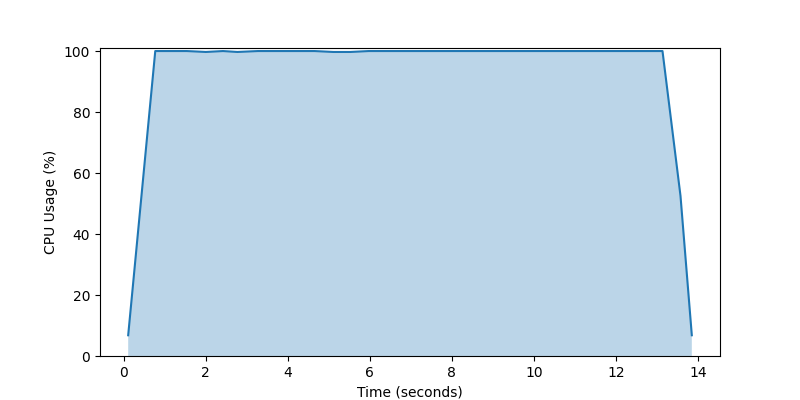

Output()

Found 0 results out of 876 filtered combinations from 1000 samples.
Total time 13.75569462776184 running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.
Pacti compose,quotient,merge statistics:
min: (compose: 3, quotient: 0, merge: 0)
max: (compose: 116, quotient: 0, merge: 0)
avg: (compose: 56.06506849315068, quotient: 0.0, merge: 0.0)
min/max compose size: (constraints: 2, variables: 2)/(constraints: 7, variables: 6)
min/max quotient size: (constraints: inf, variables: inf)/(constraints: 0, variables: 0)
min/max merge size: (constraints: inf, variables: inf)/(constraints: 0, variables: 0)



In [14]:
l_bounds = [
    4, # n123
    2, # p123
    4, # n4
    2, # p4
    4, # n5
    2, # p5
    ]

u_bounds = [
    16,     # n123
    6,      # p123
    16,     # n4
    6,      # p4
    16,     # n5
    6,      # p5
    ]

def check_parameters(n123: int, p123: int, n4: int, p4: int, n5: int, p5: int) -> bool:
    if n123 <= p123:
        return False
    if n4 <= p4:
        return False
    if n5 <= p5:
        return False
    return True

import numpy as np
from scipy.stats import qmc
sampler: qmc.LatinHypercube = qmc.LatinHypercube(d=len(l_bounds))

nb_samples = 1000

unscaled_sample: np.ndarray = sampler.random(n=nb_samples)
scaled_sample: np.ndarray = qmc.scale(sample=unscaled_sample, l_bounds=l_bounds, u_bounds=u_bounds)
filtered_sample: np.ndarray = [sample for sample in scaled_sample if check_parameters(*sample)]

def calculate_composition_with_input_bounds(params: Tuple[int]) -> Tuple[PolyhedralContractCounts, PolyhedralContract | None]:
    return example_composition_with_input_bounds(*params)

import time
from typing import List, Tuple
from p_tqdm import p_umap
from cpu_usage_plot import cpu_usage_plot

with cpu_usage_plot():
    ta = time.time()
    results = p_umap(calculate_composition_with_input_bounds, filtered_sample)
    tb = time.time()

stats = polyhedral_count_stats([result[0] for result in results])
filtered_results = [results[1] for result in results if not results[1]]

print(
    f"Found {len(filtered_results)} results out of {len(filtered_sample)} filtered combinations from {len(scaled_sample)} samples.\n"
    f"Total time {tb-ta} running on {cpu_info_message}\n"
    f"{stats.stats()}"
)